# Dark Energy Camera Legacy Survey (DECaLS)

- Telescope: Blanco 4m telescope, located at Cerro Tololo Inter-American Observatory
- Footprint: Basically Northern sky
- Bands: $g,\ r,\ z$
- Current Data Release: [DR7](http://legacysurvey.org) (DR8 will come out soon)
- Beautiful picture gallery: http://portal.nersc.gov/project/cosmo/data/legacysurvey/dr7/gallery/
- Sky viewer: http://legacysurvey.org/viewer#NGC%204849

In [31]:
DECaLS_pixel_scale = 0.262 # arcsec/pixel

In [39]:
# Import packages
%matplotlib inline
import os
import urllib

import numpy as np

import matplotlib.pyplot as plt

from kungpao.display import display_single
import astropy.wcs as wcs
from astropy.io import fits
from astropy.table import Table, Column

## [`survey-bricks-dr7.fits.gz`](http://legacysurvey.org/dr7/files/#id4): Bricks: 0.25 deg * 0.25 deg

In [5]:
bricks = Table.read('/Users/jiaxuanli/Research/SideProjects/low-z-galaxy-survey/Catalogs/survey-bricks-dr7.fits', 
                    format='fits')
bricks[:10]

brickname,ra,dec,nexp_g,nexp_r,nexp_z,nexphist_g [6],nexphist_r [6],nexphist_z [6],nobjs,npsf,nsimp,nrex,nexp,ndev,ncomp,psfsize_g,psfsize_r,psfsize_z,psfdepth_g,psfdepth_r,psfdepth_z,galdepth_g,galdepth_r,galdepth_z,ebv,trans_g,trans_r,trans_z,ext_g,ext_r,ext_z,wise_nobs [4],trans_wise [4],ext_w1,ext_w2,ext_w3,ext_w4
bytes8,float64,float64,int16,int16,int16,int32,int32,int32,int16,int16,int16,int16,int16,int16,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int16,float32,float32,float32,float32,float32
0001m002,0.125,-0.25,5,6,4,24968 .. 6051172,19578 .. 10474241,46299 .. 1907982,5644,2490,0,2434,523,188,9,1.65967,1.29243,1.06819,24.7907,24.6453,23.6879,24.5864,24.3264,23.2938,0.0340257,0.904183,0.934402,0.96276,0.109359,0.0736658,0.0412052,138 .. 12,0.99425 .. 0.999715,0.00626074,0.00384491,0.000819989,0.00030964
0001m005,0.125,-0.5,4,6,3,165942 .. 765767,1201 .. 10280579,4213 .. 0,5567,1983,0,2672,644,253,15,1.65217,1.28329,1.07835,24.6787,24.6434,23.5444,24.4604,24.3206,23.1648,0.0411695,0.885263,0.921186,0.955119,0.132319,0.0891319,0.0498563,134 .. 13,0.993047 .. 0.999655,0.00757517,0.00465215,0.000992209,0.000374635
0001m007,0.125,-0.75,6,6,3,134912 .. 7403070,913 .. 7786008,4162 .. 0,5644,2042,0,2661,630,295,16,1.84004,1.3274,1.07838,24.7693,24.5481,23.5534,24.5852,24.26,23.1733,0.0434671,0.879263,0.916975,0.952675,0.139703,0.0941062,0.0526386,135 .. 14,0.992661 .. 0.999636,0.00799799,0.00491183,0.00104759,0.000395545
0001m010,0.125,-1.0,7,4,3,21928 .. 10336513,41046 .. 3852408,37619 .. 0,5628,2194,0,2619,557,239,19,1.81053,1.32273,1.04307,24.9012,24.5645,23.491,24.7119,24.2646,23.0827,0.0379782,0.893666,0.927067,0.958525,0.122062,0.0822227,0.0459916,134 .. 12,0.993585 .. 0.999682,0.00698797,0.00429156,0.000915261,0.000345633
0001m012,0.125,-1.25,7,4,4,845 .. 10098566,1568 .. 5704276,2248 .. 0,5396,2211,0,2417,546,202,20,1.77655,1.3105,1.05563,24.9029,24.6681,23.6262,24.7114,24.3699,23.2254,0.040893,0.885988,0.921694,0.955414,0.13143,0.0885333,0.0495214,133 .. 13,0.993094 .. 0.999657,0.00752427,0.00462089,0.000985538,0.00037211
0001m015,0.125,-1.5,6,3,3,772 .. 10664263,2803 .. 0,3131 .. 0,5885,2411,0,2648,585,224,17,1.85249,1.25601,1.06153,24.831,24.5992,23.5037,24.6541,24.2806,23.1146,0.03662,0.897266,0.929581,0.959978,0.117697,0.0792823,0.0443468,133 .. 13,0.993813 .. 0.999693,0.00673808,0.00413805,0.000882552,0.000333268
0001m017,0.125,-1.75,7,4,4,910 .. 10207630,3259 .. 0,3261 .. 0,5976,2372,0,2730,600,255,19,1.83446,1.24132,1.04955,24.8729,24.6739,23.6398,24.6938,24.3591,23.2355,0.0356872,0.899747,0.931311,0.960977,0.114699,0.0772627,0.0432172,130 .. 12,0.99397 .. 0.999701,0.00656644,0.00403262,0.000860078,0.000324723
0001m020,0.125,-2.0,6,3,4,4502 .. 10354889,9952 .. 436192,18717 .. 0,5931,2421,0,2647,603,252,8,1.82885,1.24687,1.04141,24.839,24.5658,23.6487,24.6504,24.2644,23.2396,0.0368065,0.896771,0.929235,0.959778,0.118296,0.0796861,0.0445727,122 .. 12,0.993782 .. 0.999692,0.0067724,0.00415916,0.000887021,0.000334951
0001m022,0.125,-2.25,7,4,4,1142 .. 10813421,2814 .. 2713220,5171 .. 2628781,5988,2454,0,2671,627,215,21,1.7899,1.28889,1.03238,24.9506,24.59,23.6739,24.762,24.2933,23.2555,0.0365457,0.897464,0.929718,0.960057,0.117458,0.0791215,0.0442569,120 .. 10,0.993826 .. 0.999694,0.00672447,0.00412967,0.000880739,0.000332556


## Download the jpeg image of a given coordinate

In [32]:
# Generate DECaLS jpeg cutout url
def gen_url_decals_jpeg(ra_cen, dec_cen, size, bands, layer='decals-dr7', pixel_unit=False):
    '''Generate jpeg image url of given position.
    
    Parameters:
    -----------
    ra: float, RA (degrees)
    dec: float, DEC (degrees)
    size: float, image size (pixel)
    bands: string, such as 'r' or 'gri'
    layer: string, edition of data release
    pixel_unit: boolean. If true, size will be in pixel unit.

    Returns:
    -----------
    url: list of str, url of S18A image.  
    '''
    if pixel_unit:
        return ['http://legacysurvey.org/viewer/jpeg-cutout?ra=' 
                + str(ra_cen) 
                + '&dec=' 
                + str(dec_cen) 
                + '&layer=' 
                + layer 
                + '&size=' 
                + str(size) 
                + '&pixscale=' 
                + str(DECaLS_pixel_scale) 
                + '&bands=' 
                + bands]
    else:
        return ['http://legacysurvey.org/viewer/jpeg-cutout?ra=' 
                + str(ra_cen) 
                + '&dec=' 
                + str(dec_cen) 
                + '&layer=' 
                + layer 
                + '&size=' 
                + str(int(size/DECaLS_pixel_scale))
                + '&pixscale=' 
                + str(DECaLS_pixel_scale) 
                + '&bands=' 
                + bands]

In [21]:
ra = 217.419294 
dec = 0.366394

In [27]:
url = gen_url_decals_jpeg(ra, dec, 500, 'grz', layer='decals-dr7', pixel_unit=True)[0]
urllib.request.urlretrieve(url, filename='./decals_jpeg.jpg')

('./decals_jpeg.jpg', <http.client.HTTPMessage at 0x21da1d710>)

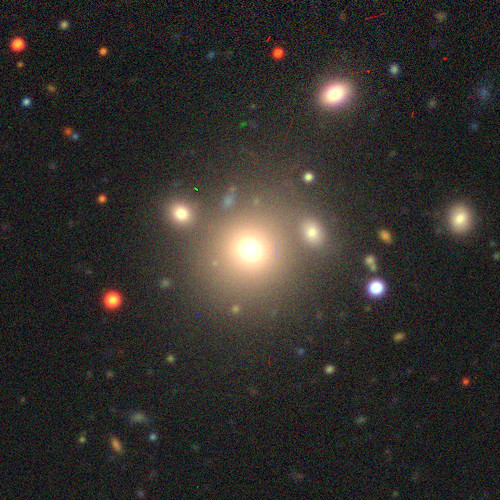

In [28]:
from PIL import Image
Image.open('./decals_jpeg.jpg')

## Download the `fits` cutout of a given coordinate

In [33]:
# Generate DECaLS image url
def gen_url_decals(ra, dec, size, bands, layer='decals-dr7', pixel_unit=False):
    '''Generate fits image url of given position.
    
    Parameters:
    -----------
    ra: float, RA (degrees)
    dec: float, DEC (degrees)
    size: float, image size (pixel)
    bands: string, such as 'r' or 'gri'
    layer: string, edition of data release
    pixel_unit: boolean. If true, size will be in pixel unit.

    Returns:
    -----------
    url: list of str, url of DECaLS image.  
    '''

    if pixel_unit:
        return ['http://legacysurvey.org/viewer/fits-cutout?ra='
            + str(ra)
            + '&dec='
            + str(dec)
            + '&pixscale='
            + str(DECaLS_pixel_scale)
            + '&layer='
            + layer
            + '&size='
            + str(size)
            + '&bands='
            + bands]
    else:        
        return ['http://legacysurvey.org/viewer/fits-cutout?ra='
            + str(ra)
            + '&dec='
            + str(dec)
            + '&pixscale='
            + str(DECaLS_pixel_scale)
            + '&layer='
            + layer
            + '&size='
            + str(size/DECaLS_pixel_scale)
            + '&bands='
            + bands]

In [34]:
url = gen_url_decals(ra, dec, 500, 'r', layer='decals-dr7', pixel_unit=True)[0]
urllib.request.urlretrieve(url, filename='./decals_cutout.fits')

('./decals_cutout.fits', <http.client.HTTPMessage at 0x21da23048>)

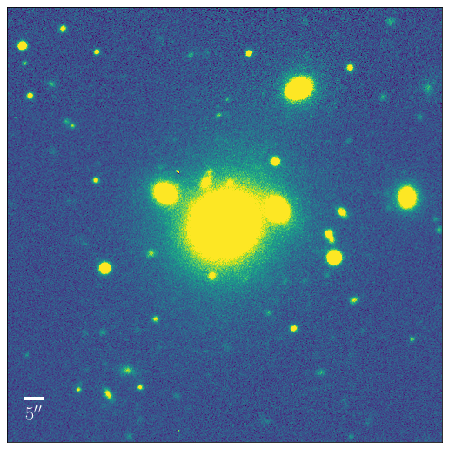

In [42]:
img = fits.open('./decals_cutout.fits')[0].data
display_single(img, pixel_scale=DECaLS_pixel_scale);

## `the tractor` catalogs: http://legacysurvey.org/dr7/catalogs/
`tractor` residual map: http://legacysurvey.org/viewer#IC%202971